# Chap.11 さまざまな教師あり学習：回帰

## 11.1 リッジ回帰

In [21]:
# ライブラリの準備
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [5]:
# 11-2 データセットの準備
# csvの読み込み
df = pd.read_csv('../support/datafiles/Boston.csv')
# 欠損値補完
df = df.fillna(df.mean())
# 外れ値の行を削除
df = df.drop([76], axis=0)

# 正解データ抜き出し
t = df[['PRICE']]
# 特徴量抜き出し
x = df.loc[:, ['RM', 'PTRATIO', 'LSTAT']]

# 標準化
sc = StandardScaler()
sc_x = sc.fit_transform(x)

sc2 = StandardScaler()
sc_t = sc2.fit_transform(t)

/var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/ipykernel_23791/870091991.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [6]:
# 11-3 累乗列と交互作用特徴量を追加する
pf = PolynomialFeatures(degree=2, include_bias=False)
# 2乗列と交互作用項の追加
pf_x = pf.fit_transform(sc_x)
# 行数と列数
pf_x.shape

(99, 9)

In [7]:
# 11-4 追加した 累乗列と交互作用特徴量の列名を確認する
pf.get_feature_names()


/Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/Introduction_to_Machine_Learning_with_Python_Imp/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

In [10]:
# 11-5 線形回帰で過学習が起こることを確認する
x_train, x_test, y_train, y_test = train_test_split(
    pf_x, sc_t, test_size=0.3, random_state=0
)
model = LinearRegression()
model.fit(x_train, y_train)

# 訓練データの決定係数
print(model.score(x_train, y_train))
# テストデータの決定係数
model.score(x_test, y_test)

0.8710525685992707


0.7854929935582586

In [13]:
# 11-6 リッジ回帰で過学習が起こるか確認する

# モデルの作成
ridgeModel = Ridge(alpha=10)
# 学習
ridgeModel.fit(x_train, y_train)

print(ridgeModel.score(x_train, y_train))
print(ridgeModel.score(x_test, y_test))

0.8607320524729507
0.8458730019328173


In [14]:
# 11-7 正則化項の定数を0.01~20まで0.01刻みで検証する
maxScore = 0
maxIndex = 0

for i in range(1, 2001):
    num = i / 100
    ridgeModel = Ridge(random_state=0, alpha=num)
    ridgeModel.fit(x_train, y_train)

    result = ridgeModel.score(x_test, y_test)
    if result > maxScore:
        maxScore = result
        maxIndex = num

print(maxIndex, maxScore)

17.62 0.852875480149763


In [15]:
# 11-8 重回帰とリッジ回帰の係数の大きさを比較する

# 線形回帰の係数（絶対値）
print(sum(abs(model.coef_)[0]))
# リッジ回帰の合計
print(sum(abs(ridgeModel.coef_)[0]))

1.5566745983288364
1.2152800824026817


## 11.2 ラッソ回帰

In [18]:
# 11-9 ラッソ回帰モデルで過学習が起きていないか確認する
model = Lasso(alpha=0.1)
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.8224680202036665
0.858846785318774


In [19]:
# 11-10 回帰式の係数を確認する
weight = model.coef_
pd.Series(weight, index=pf.get_feature_names())

/Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/Introduction_to_Machine_Learning_with_Python_Imp/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x0       0.409426
x1      -0.083104
x2      -0.287714
x0^2     0.150001
x0 x1   -0.000000
x0 x2   -0.037450
x1^2    -0.000000
x1 x2    0.000000
x2^2     0.000000
dtype: float64

## 11.3 回帰木

In [20]:
# 11-11 ボストンの住宅価格のデータを読み込む
df = pd.read_csv('../support/datafiles/Boston.csv')
df = df.fillna(df.mean())
x = df.loc[:, 'ZN':'LSTAT']
t = df['PRICE']

x_train, x_test, y_train, y_test = train_test_split(
    x, t, test_size=0.3, random_state=0
)


/var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/ipykernel_23791/3808134316.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [22]:
# 11-12 回帰木を用いた学習

# 木の深さの最大を10に設定
model = DecisionTreeRegressor(max_depth=10, random_state=0)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.59433275545417

In [23]:
# 11-13 特徴量の重要度を参照する
pd.Series(model.feature_importances_, index=x.columns)

ZN         0.000252
INDUS      0.007301
CHAS       0.000000
NOX        0.001967
RM         0.759547
AGE        0.139388
DIS        0.013635
RAD        0.000404
TAX        0.013975
PTRATIO    0.001913
B          0.003331
LSTAT      0.058287
dtype: float64

## 11.5 練習問題

In [28]:
# ライブラリの準備
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [25]:
# データの準備
df = pd.read_csv('../support/datafiles/Bank.csv')
print(df.shape)
df.head()

(27128, 16)


,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756.0,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443.0,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436.0,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474.0,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354.0,no,no,cellular,30,apr,NaN,1,2,0


In [26]:
# ダミー変数化のため、文字列の列が複数あるので抜き出す。
str_col_name=[
    'job', 'default', 'marital', 'education', 'housing', 
    'loan', 'contact', 'month'
]
str_df = df[str_col_name]

# 複数列をダミー変数化
str_df2 = pd.get_dummies(str_df, drop_first=True)
# 数値列を抜き出す
num_df = df.drop(str_col_name, axis=1)
# 結合(今後の集計の利便性も考慮してstr_dfも結合しておく)
df2 = pd.concat([num_df, str_df2, str_df], axis=1)

In [27]:
# 訓練&検証データとテストデータに分割
train_val, test = train_test_split(df2, test_size=0.1, random_state=9)
train_val.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
13378,13379,46,0.0,10,378.293875,1,0,1,0,0,...,0,0,unemployed,no,married,tertiary,yes,no,cellular,jul
3800,3801,41,-333.0,30,300.845752,3,2,0,1,0,...,0,0,blue-collar,no,divorced,secondary,yes,no,cellular,jan
10398,10399,30,5389.0,6,159.053623,3,0,1,0,0,...,0,0,management,no,single,tertiary,no,no,cellular,aug
23401,23402,39,255.0,5,334.802583,1,0,0,0,0,...,0,0,management,no,single,tertiary,yes,no,sending _document,may
26223,26224,47,33.0,5,NaN,1,0,1,0,0,...,0,0,services,no,single,secondary,yes,no,cellular,may


In [29]:
# 線形回帰は外れ値の影響を強く受けるので調べる。
num_df = train_val.drop(str_col_name, axis=1)
num_df = num_df.drop('id', axis=1)
num_df2 = num_df.dropna()
mcd2 = MinCovDet(random_state=0, support_fraction=0.7)
mcd2.fit(num_df2)

MinCovDet(random_state=0, support_fraction=0.7)

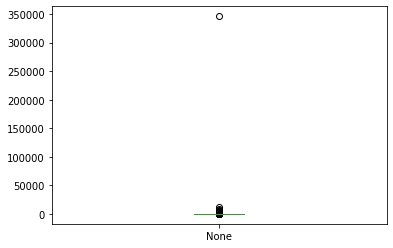

In [30]:
dis = mcd2.mahalanobis(num_df2)
dis = pd.Series(dis)
dis.plot(kind="box")
no = dis[dis > 300000].index
# 先頭から2561番目が外れ値となる事が分かったので９章の付録で紹介したilocを利用する
no = num_df2.iloc[no[0]:(no[0]+1), :].index
train_val2 = train_val.drop(no)

In [31]:
# 欠損行を削除
not_nan_df = train_val2.dropna()
temp_t =not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name,axis=1)

# durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y', 'duration', 'id'], axis=1)

a, b, c, d = train_test_split(
    temp_x, temp_t, random_state=0, test_size=0.2
)
maxvalue = 0
v = 0
# 今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1, 42):
    val = i/20
    model_liner = Lasso(random_state=0, alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a, c)
    if maxvalue < model_liner.score(b, d):
        v = val
        maxvalue = model_liner.score(b, d)
print(v, maxvalue)

0.15 0.7304944115519963


In [33]:
model_liner = Lasso(random_state=0, alpha=v)
# 今回は予測させたいだけなので、標準化はしない
model_liner.fit(a, c)
pd.Series(model_liner)


0    Lasso(alpha=0.15, random_state=0)
dtype: object

- 考え方をここで変える。
- durationとyに関係が強いという仮定が正しいならば、durationを推定するのにyを利用するのは合理的ではなかろうか？
- ただテストデータでは、yの値が本当に未知という状況で検証するのでテストデータでもdurationが欠損している場合は上記model_linerを利用する。

In [34]:
# 欠損行を削除
not_nan_df = train_val2.dropna()
temp_t = not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name, axis=1)
# yを消さない
temp_x = temp_x.drop(['duration', 'id'], axis=1)

a, b, c, d = train_test_split(temp_x, temp_t, random_state=0, test_size=0.2)
maxvalue = 0
v = 0
for i in range(1, 42):
    val = i/20
    model_liner2 = Lasso(random_state=0, alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner2.fit(a, c)
    if maxvalue < model_liner2.score(b, d):
        v = val
        maxvalue = model_liner2.score(b, d)
print(v, maxvalue)

0.1 0.8192780104182655


In [35]:
# 結果
pd.Series(model_liner2.coef_, index=temp_x.columns)

age                            3.685596
amount                        -0.000010
day                           -0.000000
campaign                      -0.000000
previous                       2.951859
y                             41.674580
job_blue-collar                0.000000
job_entrepreneur              -0.000000
job_housemaid                 -0.000000
job_management                -0.000000
job_retired                   -0.000000
job_self-employed              0.000000
job_services                   0.000000
job_student                   -0.000000
job_technician                 0.000000
job_unemployed                -0.000000
job_unknown                   -0.000000
default_yes                    0.000000
marital_married                0.000000
marital_single                -0.000000
education_secondary            0.000000
education_tertiary            -0.000000
education_unknown             -0.000000
housing_yes                  127.082018
loan_yes                      82.595567


In [36]:
train_val3 = train_val.copy()
is_null = train_val3['duration'].isnull()
temp_x = train_val3.drop(str_col_name, axis=1)
temp_x = temp_x.drop(['duration','id'], axis=1)
temp_x = temp_x[is_null]
#non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner2.predict(temp_x)
train_val3.loc[is_null, 'duration'] = pred_d

(24415, 48)

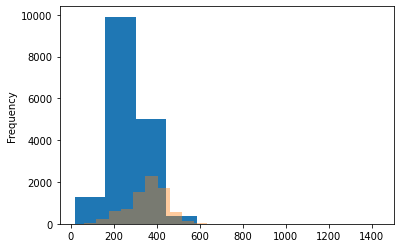

In [37]:
# ヒストグラムの確認
train_val3.loc[train_val3['y'] == 0, "duration"].plot(kind="hist")
train_val3.loc[train_val3['y'] == 1, "duration"].plot(kind="hist", alpha=0.4)

#y=1の方が、durationが大きい傾向がやっぱりありそう
train_val3.shape


In [38]:
train_val3["duration"].describe()

count    24415.000000
mean       297.012163
std         92.504680
min         19.038719
25%        227.001265
50%        292.726974
75%        362.290315
max       1435.488040
Name: duration, dtype: float64

In [39]:
# さくっと学習できるようなlearn関数を定義する。
def learn(x, t, i):
    x_train, x_val, y_train, y_val = train_test_split(
        x, t, test_size=0.2, random_state=13
    )

    datum = [x_train, x_val, y_train, y_val]

    # 不均衡データに対応できるように、class_weight引数も設定
    model = tree.DecisionTreeClassifier(
        max_depth=i, random_state=i, class_weight='balanced'
    )
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    val_score = model.score(x_val, y_val)

    return train_score, val_score,model, datum

t = train_val3['y']
x = train_val3.drop(str_col_name, axis=1)
x = x.drop(['id', 'y', 'day'], axis=1)

# とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(1, 15):
    s1, s2, model, datum = learn(x, t, i)
    print(i, s1, s2)

1 0.754351832889617 0.7565021503174278
2 0.754351832889617 0.7565021503174278
3 0.7117038705713701 0.708171206225681
4 0.7706328077001843 0.7765717796436616
5 0.7595740323571575 0.7513823469178783
6 0.7923919721482695 0.7855826336268688
7 0.8189637517919311 0.8046283022731927
8 0.8383166086422281 0.8220356338316609
9 0.8561847225066558 0.8193733360638952
10 0.8741040344050789 0.821421257423715
11 0.8882346917878353 0.8179397911120213
12 0.9068195781281999 0.8185541675199672
13 0.9212062256809338 0.810976858488634
14 0.9369752201515462 0.8130247798484538


- 深さ8 検証データの正解率が0.82 

pred     0     1
true            
0     2825   558
1      311  1189 

             id       age    amount       day  duration  campaign  previous  \
8008  -0.707324 -0.276656 -0.428811  0.742736 -0.004730 -0.238912 -0.227081   
5734  -0.997343  1.138307 -0.502345 -0.814295  0.602096 -0.557919 -0.227081   
1594  -1.525346 -0.653980  0.232995  1.581138 -1.348850 -0.238912 -0.227081   
2167  -1.452267 -0.370987 -0.213200  1.820681 -0.364601 -0.238912 -0.227081   
10468 -0.393584 -0.276656 -0.429810 -0.934067 -0.650517 -0.557919  0.162997   
...         ...       ...       ...       ...       ...       ...       ...   
1548  -1.531213 -0.182325 -0.406518  1.700910  0.451688 -0.557919 -0.227081   
508   -1.663851 -0.748311 -0.533290 -0.934067 -1.388452 -0.557919 -0.227081   
7200  -0.810374 -1.031304  0.011727  0.622965 -0.068806 -0.238912 -0.227081   
9861  -0.470999 -0.370987 -0.412508  0.143878 -0.852102  0.399101 -0.227081   
20515  0.887779  0.666653  0.128184 -0.694524  0.757940 -0.55

<AxesSubplot:>

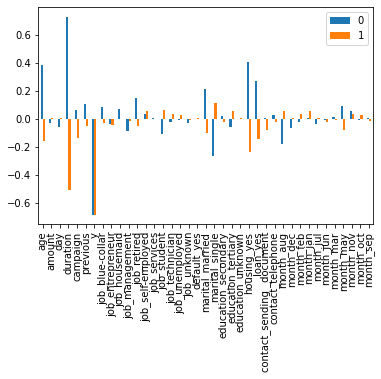

In [41]:
# どのような間違い方をしているのか確認
s1, s2, model, datum = learn(x, t, 8)

# 訓練データでの予測結果と実際の値の2軸で個数集計flagがFalseならば、検証データで集計
def syuukei(model, datum, flag=False):
    if flag:
        pre = model.predict(datum[0])
        y_val = datum[2]
    else:
        pre = model.predict(datum[1])
        y_val = datum[3]
    data = {
        "pred": pre,
        "true": y_val
    }
    tmp = pd.DataFrame(data)
    return (
        tmp, 
        pd.pivot_table(
            tmp, index="true", columns="pred", values="true", aggfunc=len
        )
    )


tmp, a = syuukei(model, datum, False)
print(a, "\n")

false = tmp.loc[(tmp['pred'] == 1) & (tmp['true'] == 0)].index
true = tmp.loc[(tmp['pred'] == 0) & (tmp['true'] == 0)].index

true_df = train_val3.loc[true]
false_df = train_val3.loc[false]

sc = StandardScaler()
tmp2 = train_val3.drop(str_col_name, axis=1)
sc_data = sc.fit_transform(tmp2)
sc_df = pd.DataFrame(sc_data, columns=tmp2.columns, index=tmp2.index)

true_df = sc_df.loc[true]
false_df = sc_df.loc[false]
print(true_df)

temp2 = pd.concat([false_df.mean()["age":], true_df.mean()["age":]], axis=1)
temp2.plot(kind="bar")


In [42]:
# 交互作用項を付けてみる
train_val4 = train_val3.copy()
train_val4['du*hou'] = train_val3['duration'] * train_val3['housing_yes']
train_val4['du*loan'] = train_val3['duration'] * train_val3['loan_yes']
train_val4['du*age'] = train_val3['duration'] * train_val3['age']

t = train_val4['y']
"""
monthcol=['month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']
#jobcol=['job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown']
"""

x = train_val4.drop(str_col_name, axis=1)

#x = x.drop(jobcol,axis=1)

#x = x.drop(monthcol,axis=1)
x = x.drop(['id', 'y', 'day'], axis=1)
x.columns

Index(['age', 'amount', 'duration', 'campaign', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'default_yes', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'education_unknown', 'housing_yes', 'loan_yes',
       'contact_sending _document', 'contact_telephone', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'du*hou', 'du*loan', 'du*age'],
      dtype='object')

In [43]:
# とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(5, 15):
    s1, s2, model, datum = learn(x, t, i)
    print(i, s1, s2)

5 0.7591644480851936 0.7505631783739505
6 0.7908560311284046 0.7823059594511571
7 0.8201925046078231 0.8058570550890846
8 0.8384190047102191 0.8191685439279132
9 0.8520376817530206 0.8083145607208683
10 0.8697010034814663 0.8103624820806881
11 0.8894634446037272 0.8179397911120213
12 0.9051300430063486 0.8087241449928323
13 0.9208990374769609 0.8101576899447062
14 0.9347737046897399 0.8117960270325619


In [44]:
# 深さ８で正解率81% 先ほどより低下した。よって交互作用項は取る。
train_val4 = train_val3.copy()
t = train_val4['y']
x = train_val4.drop(str_col_name, axis=1)
x = x.drop(['id', 'y', 'day'], axis=1)
i = 8
model = tree.DecisionTreeClassifier(
    max_depth=i, random_state=i, class_weight="balanced"
)
model.fit(x, t)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=8)

In [45]:
# テストデータでも調べる
test2 = test.copy()    
isnull = test2['duration'].isnull()
print(isnull.shape)

if isnull.sum() > 0:
    temp_x = test2.drop(str_col_name, axis=1)
    temp_x = temp_x.drop(['y', 'duration', 'id'], axis=1)
    #print(temp_x.shape[0])
    temp_x = temp_x[isnull]
    #ここではmodel_linerで調べる
    pred_d = model_liner.predict(temp_x)
    test2.loc[isnull,'duration'] = pred_d
    
x_test = test2.drop(str_col_name, axis=1)
x_test = x_test.drop(['id', 'y', 'day'], axis=1)
y_test = test['y']
x_test.columns
model.score(x_test, y_test)

(2713,)


0.7648359749354957

- もしかしたら、テストデータにも結構durationの欠損値があるのかもしれない
- （テストデータなので確認できない）
- よってmodel_linerによる不適切なduration推定をしているかもしれない。。。

- 10章で仮説を3つ挙げた
- 精度が上がりづらい原因の仮説⇒ 
  - 1．現状の線形回帰だと訓練&検証に過学習してしまい、テストデータにフィットしない。
  - （そもそもテストデータではdurationがあまり関係していない？？）
  - 2. 純粋な決定木の限界？
  - 3. 現在考慮していない特徴量ももっとしっかりした方が良いのか？？

- 考察
  - 今回、過学習しづらいlasso回帰を利用したので、10章よりは1の可能性が減るはずだが、性能はあまり変わらない。
  - 現状の知識では、1の可能性は低い。
  - よって2か3の可能性を次章以降で探る
  - （ただし、2と1の組み合わせなどは可能性としてあることに注意）